In [1]:
import os

import torch
from tempo.models import NewTempoLinear
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.transforms import Compose, Resize, ToTensor, InterpolationMode, Grayscale, GaussianBlur, Normalize
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient

from zennit.image import imgify, imsave

In [2]:
MODEL_NAME = "vanilla.pth"

In [3]:
# load models
weights_tp = torch.load(f'../model_zoo/{MODEL_NAME}')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [4]:
def get_relevance(model, data, num_classes):

    with torch.no_grad():
        pred = torch.argmax(model(data).flatten()).item()

    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # choose a target class for the attribution (label 437 is lighthouse)
    target = torch.eye(num_classes)[[pred]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(data, target)

    relevance = attribution.sum(1)

    return pred, relevance

In [5]:
images = {image[:8]: "imgsFine/leftImg8bit/Test/"+image for image in os.listdir("imgsFine/leftImg8bit/Test")}
masks = {mask[:8]: "gtFine/Test/"+mask for mask in os.listdir("gtFine/Test") if mask.endswith("color.png")}

In [6]:
transform_img = Compose([
    Resize(128, interpolation=InterpolationMode.NEAREST),
    ToTensor(),
])

transform_msk = Compose([
    Resize(128, interpolation=InterpolationMode.NEAREST),
    Grayscale(),
    ToTensor(),
])

In [7]:
def get_fat_mask(mask: Image) -> torch.FloatTensor:
    # widen the mask
    mask = transform_msk(mask)

    mask_blur = GaussianBlur(kernel_size=3)(mask)
    mask_blur = (mask_blur > 0).to(float)
    mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
    mask_blur = (mask_blur > 0).to(float)

    return mask_blur

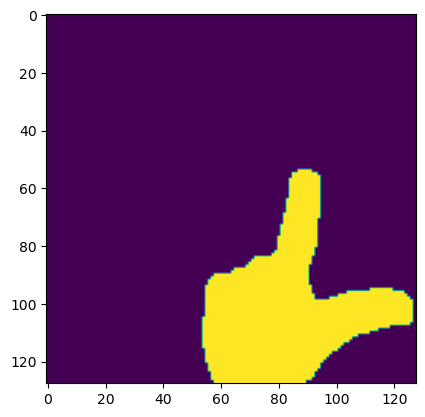

In [8]:
name1 = list(images.keys())[0]

image = transform_img(Image.open(images[name1]))
mask = get_fat_mask(Image.open(masks[name1]))

plt.imshow(mask.permute(1,2,0))

In [9]:
dataset = [(transform_img(Image.open(images[name])), get_fat_mask(Image.open(masks[name]))) for name in list(images.keys())]

In [10]:
def rof(heatmap: torch.FloatTensor, mask: torch.FloatTensor) -> float:
    heat_total = heatmap.sum().item()
    heat_inside = (heatmap * mask).sum().item()
    
    return heat_inside / heat_total

In [11]:
rofs_tp = []
rofs_bl = []

for img, msk in dataset:
    data = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)[None]
    _, heatmap_tp = get_relevance(model_tp, data, num_classes=24)
    _, heatmap_bl = get_relevance(model_bl, data, num_classes=24)

    rof_tp = rof(heatmap_tp, msk)
    rof_bl = rof(heatmap_bl, msk)

    rofs_tp.append(rof_tp)
    rofs_bl.append(rof_bl)

    print(f"Tempo: {rof(heatmap_tp, msk)}, Baseline: {rof(heatmap_bl, msk)}")

torch.tensor(rofs_tp).mean(), torch.tensor(rofs_bl).mean() 

Tempo: 0.7310643676631893, Baseline: 0.6538211564856075
Tempo: 0.7330982465051845, Baseline: 0.6004862648435708
Tempo: 0.7095254124845454, Baseline: 0.6224232602351775
Tempo: 0.6711422495583182, Baseline: 0.6401419504550205
Tempo: 0.7811425089061296, Baseline: 0.643317880517269
Tempo: 0.7165129279365784, Baseline: 0.6428706431471269
Tempo: 0.7638038151765815, Baseline: 0.6851929580778142
Tempo: 0.6947636900565572, Baseline: 0.545822104039594
Tempo: 0.7639014344575629, Baseline: 0.7247159878145255
Tempo: 0.7459748995106995, Baseline: 0.6320593829560376
Tempo: 0.7593232581104572, Baseline: 0.6429396042306966
Tempo: 0.7999292356196809, Baseline: 0.6589728701728628
Tempo: 0.7351277195817723, Baseline: 0.647914192274921
Tempo: 0.7911635548672756, Baseline: 0.6711955485872786
Tempo: 0.8289141469109743, Baseline: 0.6596835484934062
Tempo: 0.7470525684869768, Baseline: 0.6674330387547781
Tempo: 0.8495459675479227, Baseline: 0.749068905804232
Tempo: 0.8282129570269651, Baseline: 0.7605298977679

(tensor(0.7566), tensor(0.6617))